# Feature Extraction - Gradients

## Imports

In [1]:
import json
import os

import matplotlib.pyplot as plt
import numpy as np
import SimpleITK as sitk
import six
from radiomics import featureextractor
from radiomics.imageoperations import getMask
from skimage import io as skio


In [2]:
%matplotlib inline


## Hyperparameters

In [3]:
PATH_SYNTHETIQUES = os.path.join(os.getcwd(), "..", "images", "synthetiques")
PATH_RESULTS = os.path.join(os.getcwd(), "results_gradients")


In [4]:
if not os.path.exists(PATH_RESULTS):
    os.makedirs(PATH_RESULTS)


In [5]:
carreName = "carre-nb"


In [6]:
np.random.seed(0)


## Function declarations

In [7]:
class NumpyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(
            obj,
            (
                np.int_,
                np.intc,
                np.intp,
                np.int8,
                np.int16,
                np.int32,
                np.int64,
                np.uint8,
                np.uint16,
                np.uint32,
                np.uint64,
            ),
        ):
            return int(obj)
        elif isinstance(obj, (np.float_, np.float16, np.float32, np.float64)):
            return float(obj)
        elif isinstance(obj, (np.ndarray,)):
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)


In [8]:
def getGradient2D(width, height):
    return np.tile(np.linspace(0, 1, width), (height, 1))


In [9]:
def Get_values_without_error(im, XX, YY):
    """retourne une image de la taille de XX et YY
    qui vaut im[XX,YY] mais en faisant attention a ce que XX et YY ne debordent
    pas"""
    sh = XX.shape
    defaultval = 0
    if len(im.shape) > 2:  # color image !
        defaultval = np.asarray([0, 0, 0])
        sh = [*sh, im.shape[2]]
    imout = np.zeros(sh)
    (ty, tx) = XX.shape[0:2]
    for k in range(ty):
        for l in range(tx):
            posx = int(XX[k, l] - 0.5)
            posy = int(YY[k, l] - 0.5)
            if posx < 0 or posx >= im.shape[1] or posy < 0 or posy >= im.shape[0]:
                valtmp = defaultval
            else:
                valtmp = im[posy, posx]
            imout[k, l] = valtmp

    return imout


In [10]:
def rotation(im, theta, x0=None, y0=None, ech=0, clip=True):
    """
    %
    % Effectue la transformation geometrique d'une image par
    % une rotation
    %
    % x' = cos(theta)*(x-x0) - sin(theta)*(y-y0) + x0
    % y' = sin(theta)*(x-x0) + cos(theta)*(y-y0) + y0
    %
    % theta : angle de rotation en degres
    % x0, y0 : centre de la rotation (defaut=centre de l'image)
    % ech : plus proche voisin (defaut=0) ou bilineaire (1)
    % clip : format de l'image originale (defaut=True), image complete (False)
    %
    """
    dy = im.shape[0]
    dx = im.shape[1]

    if x0 is None:
        x0 = dx / 2.0
    if y0 is None:
        y0 = dy / 2.0
    v0 = np.asarray([x0, y0]).reshape((2, 1))
    theta = theta / 180 * np.pi
    ct = np.cos(theta)
    st = np.sin(theta)
    matdirect = np.asarray([[ct, -st], [st, ct]])
    if clip == False:
        # ON CALCULE exactement la transformee des positions de l'image
        # on cree un tableau des quatre points extremes
        tabextreme = np.asarray([[0, 0, dx, dx], [0, dy, 0, dy]])
        tabextreme_trans = matdirect @ (tabextreme - v0) + v0
        xmin = np.floor(tabextreme_trans[0].min())
        xmax = np.ceil(tabextreme_trans[0].max())
        ymin = np.floor(tabextreme_trans[1].min())
        ymax = np.ceil(tabextreme_trans[1].max())

    else:
        xmin = 0
        xmax = dx
        ymin = 0
        ymax = dy
    if len(im.shape) > 2:
        shout = (int(ymax - ymin), int(xmax - xmin), im.shape[2])  # image couleur
    else:
        shout = (int(ymax - ymin), int(xmax - xmin))
    dyout = shout[0]
    dxout = shout[1]
    eps = 0.0001
    Xout = np.arange(xmin + 0.5, xmax - 0.5 + eps)
    Xout = np.ones((dyout, 1)) @ Xout.reshape((1, -1))

    Yout = np.arange(ymin + 0.5, ymax - 0.5 + eps)
    Yout = Yout.reshape((-1, 1)) @ np.ones((1, dxout))

    XY = np.concatenate((Xout.reshape((1, -1)), Yout.reshape((1, -1))), axis=0)
    XY = np.linalg.inv(matdirect) @ (XY - v0) + v0
    Xout = XY[0, :].reshape(shout)
    Yout = XY[1, :].reshape(shout)
    if ech == 0:  # plus proche voisin
        out = Get_values_without_error(im, Xout, Yout)
    else:  # bilineaire
        assert ech == 1, "Vous avez choisi un echantillonnage inconnu"
        Y0 = np.floor(Yout - 0.5) + 0.5  # on va au entier+0.5 inferieur
        X0 = np.floor(Xout - 0.5) + 0.5
        Y1 = np.ceil(Yout - 0.5) + 0.5
        X1 = np.ceil(Xout - 0.5) + 0.5
        PoidsX = Xout - X0
        PoidsY = Yout - Y0
        PoidsX[X0 == X1] = 1  # points entiers
        PoidsY[Y0 == Y1] = 1  # points entiers
        I00 = Get_values_without_error(im, X0, Y0)
        I01 = Get_values_without_error(im, X0, Y1)
        I10 = Get_values_without_error(im, X1, Y0)
        I11 = Get_values_without_error(im, X1, Y1)
        out = (
            I00 * (1.0 - PoidsX) * (1.0 - PoidsY)
            + I01 * (1 - PoidsX) * PoidsY
            + I10 * PoidsX * (1 - PoidsY)
            + I11 * PoidsX * PoidsY
        )
    return out


## Feature extraction

In [11]:
carrePath = os.path.join(PATH_SYNTHETIQUES, carreName + ".tif")
carreArray = skio.imread(carrePath, plugin="matplotlib", format="tif")[:, :, 0] / 255
carre = sitk.GetImageFromArray(carreArray)
carreMask = getMask(carre)


In [12]:
gradArray = np.pad(getGradient2D(141, 141), pad_width=57, mode='constant')


In [13]:
gradArray.shape


(255, 255)

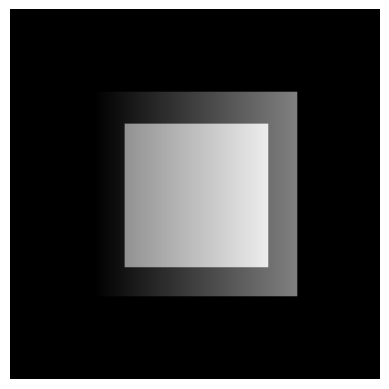

In [14]:
plt.imshow(gradArray, cmap="gray")
plt.imshow(carreArray, alpha = 0.5, cmap="gray")

plt.axis('off')
plt.show()


In [15]:
extractor = featureextractor.RadiomicsFeatureExtractor()
extractor.enableAllFeatures()

for t in np.linspace(start=0, stop=360, num=100, endpoint=False):
    rotGradArray = rotation(gradArray, t, ech=1, clip=True)
    image = sitk.GetImageFromArray(rotGradArray)

    result = extractor.execute(image, carreMask)

    feature = np.array([])

    for key, value in six.iteritems(result):
        if key.startswith("original_"):
            feature = np.append(feature, result[key])

    operation = json.dumps(result, cls=NumpyEncoder)

    with open(os.path.join(PATH_RESULTS, "%.2f_results.json" % t), "w") as f:
        f.write(operation)

    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    axs[0].imshow(rotGradArray, cmap="gray")
    axs[0].set_title("%.2f" % t)
    axs[0].axis("off")

    axs[1].imshow(sitk.GetArrayFromImage(carreMask), cmap="gray")
    axs[1].set_title("carre-nb Mask")
    axs[1].axis("off")

    plt.savefig(os.path.join(PATH_RESULTS, "%.2f_imMask.png" % t))
    plt.close(fig)

    fig = plt.figure(figsize=(10, 5))

    plt.stem(feature)
    plt.yscale("log")
    plt.title("Features from %.2f" % t)

    plt.savefig(os.path.join(PATH_RESULTS, "%.2f_results.png" % t))

    plt.close(fig)


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is 